In [4]:
import pylab as p
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import load_mnist
#from keras.datasets import mnist

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

<Figure size 1000x750 with 0 Axes>

In [5]:
# read MNIST data set and scale it
X0,y0,Xv,yv,X1,y1 = load_mnist.read([0,1,2,3,4,5,6,7,8,9], path="")
x0 = (1.0/255.0)*X0.astype('float64')
x1 = (1.0/255.0)*X1.astype('float64')
x2 = (1.0/255.0)*Xv.astype('float64')
y0 = y0.astype('float64')
y1 = y1.astype('float64')
y2 = yv.astype('float64')

MNIST, Classes:     10
Training Images:    (50000, 784)
Validation Images:  (10000, 784)
Test Images:        (10000, 784)


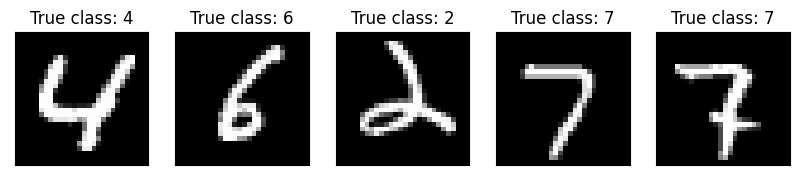

In [6]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(())

subsample = np.random.permutation(x0.shape[0])[:5]
images = x0[subsample]
labels = ['True class: %d' % np.argmax(l) for l in y0[subsample]]
plot_gallery(images, labels, shape=(28, 28))

Globale Arrays und Variablen des Netzwerkes:

In [7]:
# Netzwerkparameter
# mbs = 10                     # Größe der Minibatches
mbs = 10
# eta = 3.0                    # Lernrate
eta = 0.03
# no_hidden = 36               # Anzahl versteckter Neuronen
no_hidden = 2
# epochs = 15                  # Anzahl Epochen
epochs = 150
# sizes = [784, no_hidden, 10] # dreischichtiges MPL mit 784 Eingangs-, no_hidden versteckten, 10 Ausgangsneuronen
sizes = [2, no_hidden, no_hidden, 1]
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]]                         # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]    # Gewichte
print(weights[1].shape)

(2, 2)


Einige Hilfsfunktionen:

In [8]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

Vorwärtslauf durch das Netzwerk für Testläufe (Prädiktion):

In [9]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

Backpropagation-Algorithmus für ein Paar aus Input x und Label y:

In [10]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

Gemitteltes Update über einen Minibatch:

In [11]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

Hilfsfunktion zur Evaluation des Netzwerkes auf den Testdaten:

In [12]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    errors = []
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Label ist in one-hot-Codierung: korrekte Klasse ist 1, alle anderen 0
        # c = np.argmax(y)
        c = np.argmax(y)
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        # cpred = np.argmax(ypred)
        cpred = np.max(ypred)
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        # if c == cpred:
        #     correct += 1
        if (c == 0 and cpred < 0.5) or (c == 1 and cpred >= 0.5):
            correct += 1

        errors.append(np.square(c - cpred))

    return correct, np.mean(errors)

Stochastischer Gradientenabstieg:

In [13]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    mse = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j], mse[j] = evaluate(x2, y2)
        print("Epoch {0}: {1} / {2}".format(j, acc_val[j], n_test))
    
    return acc_val, mse

Training:

In [14]:
acc_val = SGD(x0, y0, epochs, mbs, eta, x2, y2)

ValueError: shapes (2,2) and (784,1) not aligned: 2 (dim 1) != 784 (dim 0)

Evaluation auf den unabhängigen Testdaten:

In [ ]:
print("Test accuracy: {0} / {1}".format(evaluate(x1, y1), x1.shape[0]))

Lernkurve (Genauigkeit auf Validierungsdatensatz):

In [ ]:
plt.plot(acc_val/x2.shape[0]);

Trainierte rezeptive Felder:

In [ ]:
labels = range(no_hidden)
plot_gallery(weights[0][:10,:],labels, shape=(28, 28))

In [ ]:
labels = range(10)
plot_gallery(weights[1],labels, shape=(36,1))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
train = np.array([np.random.uniform(-6.0, 6.0, 200), np.random.uniform(-6.0, 6.0, 200)]).T
df_train = pd.DataFrame(train)
df_train['labels'] = np.where((df_train[0] > 0) & (df_train[1] > 0) | (df_train[0] < 0) & (df_train[1] < 0) , 1, 0)
colors = np.where(df_train['labels'] == 1, 'blue', 'red')
plt.scatter(df_train[0], df_train[1], c = colors)


In [ ]:
test = np.array([np.random.uniform(-6.0, 6.0, 200), np.random.uniform(-6.0, 6.0, 200)]).T
df_test = pd.DataFrame(test)
df_test['labels'] = np.where((df_test[0] > 0) & (df_test[1] > 0) | (df_test[0] < 0) & (df_test[1] < 0) , 1, 0)
colors = np.where(df_test['labels'] == 1, 'blue', 'red')
plt.scatter(df_test[0], df_test[1], c = colors)
df_test

In [ ]:
#1.4
w_vert = np.array([0, 1])
w_hor = np.array([1, 0])

In [ ]:
#1.5
def neuron(x, y, w):
    X,Y = np.meshgrid(x, y)
    input = np.stack([X.flatten(), Y.flatten()]).T
    postNeuron = np.matmul(input, w)
    return sigmoid(postNeuron).reshape(X.shape)


def plot(w):
    x = np.arange(-6.0,6.0,0.12)
    y = np.arange(-6.0,6.0,0.12)
    Z = neuron(x, y, w)

    X,Y = np.meshgrid(x, y)
    plt.pcolor(X, Y, Z, cmap='winter')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plot(w_vert)
plot(w_hor)

In [ ]:
#1.6
def preprocess(df):
    data = df[[0, 1]].to_numpy()
    new_data = np.stack((sigmoid(np.dot(data, w_vert)), sigmoid(np.dot(data, w_hor))), axis = 1)
    new_df = pd.DataFrame(new_data)
    new_df['labels'] = df['labels']
    return new_df

df_train_n = preprocess(df_train)
df_test_n = preprocess(df_test)


x_grid = np.arange(-6.0,6.0,0.12)
y_grid = np.arange(-6.0,6.0,0.12)
data = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)
df_grid = pd.DataFrame(data)
df_grid['labels'] = np.where((df_grid[0] > 0) & (df_grid[1] > 0) | (df_grid[0] < 0) & (df_grid[1] < 0) , 1, 0)
df_grid_n = preprocess(df_grid)

In [ ]:
#2.3
# acc_val = SGD(x0, y0, epochs, mbs, eta, x2, y2)
x0 = df_train_n[[0, 1]].to_numpy()
y0 = df_train_n[['labels']].to_numpy()
x2 = df_test_n[[0, 1]].to_numpy()
y2 = df_test_n[['labels']].to_numpy()
acc_val, mse = SGD(x0, y0, epochs, mbs, eta, x2, y2)

In [ ]:
print("Test accuracy: {0} / {1}".format(evaluate(x1, y1), x1.shape[0]))

In [ ]:
plt.plot(acc_val/x2.shape[0]);

Aufgabe 3: \

Das Netz aus der Vorlesung verwendet als Aktivierungsfunktion den Tangens hyperbolicus (np.tanh()). Passen Sie die Funktionen sigmoid() und sigmoid_prime() entsprechend an. Achtung: kommentieren Sie den bisherigen Code für die Sigmoidfunktion nur aus, wir werden ihn in der nächsten Aufgabe nochmals benötigen. Da die Ausgangswerte von tanh im Intervall [−1,1] statt [0,1] liegen, müssen wir hierfür nochmals die Funktion evaluate() entsprechend anpassen.


In [ ]:
# Tangens hyperbolicus (vektorisiert)
def tanh(z):
    """The hyperbolic tangent function."""
    return np.tanh(z)

# Ableitung des Tangens hyperbolicus
def tanh_prime(z):
    """Derivative of the hyperbolic tangent function."""
    return 1 - tanh(z)**2

In [ ]:
# angepasste evaluate Funktion
def evaluate_tangh(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    errors = []
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Label ist in one-hot-Codierung: korrekte Klasse ist 1, alle anderen 0
        # c = np.argmax(y)
        c = np.argmax(y)
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        # cpred = np.argmax(ypred)
        cpred = np.max(ypred)
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        # if c == cpred:
        #     correct += 1
        
        # ANPASSEN: Falls beide übereinstimmen, addiere zur Gesamtzahl
        # Diese Bedingung muss angepasst werden für die neue Tangens hyperbolicus Aktivierungsfunktion !
        if (c == 0 and cpred < 0) or (c == 1 and cpred >= 0):
            correct += 1

        errors.append(np.square(c - cpred))

    return correct, np.mean(errors)

Aufgabe 4: \
Eine alternative, besser an das Klassifikationsszenario angepasste Kostenfunktion statt des MSE ist die Kostenfunktion für die logistische Regression.

In [ ]:
# Ableitung der Kostenfunktion für die logistische Regression
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return -y * np.log(output_activations) - (1 - y) * np.log(1 - output_activations)


# Überprüfen der Genauigkeit des neuronale Netzwerks
accuracy, error = evaluate(x2, y2)
print(f"Accuracy: {accuracy}/{x2.shape[0]} ({accuracy / x2.shape[0] * 100}%)")




NameError: name 'evaluate' is not defined